# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

## Classe e funções auxiliares

In [ ]:
class SimpleLinearModel(nn.Module):
    """
    Um modelo linear simples que pode ser usado tanto para regressão
    quanto para classificação binária.
    """
    def __init__(self, in_features, out_features=1):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def run_training_loop(model, X, y, loss_fn, optimizer, epochs=200, desc="Treinando o modelo"):
    """
    Executa um laço de treinamento padrão para um dado modelo.
    """
    losses = []
    iterator = tqdm(range(epochs), desc=desc)
    for epoch in iterator:
        # Forward pass
        y_pred = model(X)

        # Calcula a perda
        loss = loss_fn(y_pred, y)

        # Lida com o caso de perda NaN (divergência)
        if torch.isnan(loss):
            print(f"\nPerda se tornou NaN na época {epoch}. Interrompendo.")
            losses.extend([losses[-1] if losses else 1e10] * (epochs - len(losses)))
            break

        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    final_loss = losses[-1] if losses else float('inf')
    print(f"\nTreinamento concluído! Perda final: {final_loss:.4f}")
    return losses

In [ ]:
def plot_decision_boundary(model, X, y, title):
    """
    Plota a fronteira de decisão para um modelo de classificação binária.
    """
    X_np = X.numpy()
    y_np = y.numpy().flatten()

    x_min, x_max = X_np[:, 0].min() - 0.2, X_np[:, 0].max() + 0.2
    y_min, y_max = X_np[:, 1].min() - 0.2, X_np[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    with torch.no_grad():
        Z = torch.sigmoid(model(grid_tensor)).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z > 0.5, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title(title)
    plt.xlabel('Feature 1 ($x_1$)')
    plt.ylabel('Feature 2 ($x_2$)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

## Exercícios: Regressão Linear

### Exercício 1: Regressão Linear Múltipla com Dados Sintéticos

Até agora, nosso modelo usou apenas uma variável de entrada ($x$) para prever a saída ($y$). Na prática, a maioria dos problemas envolve múltiplas variáveis de entrada (features). Sua tarefa é adaptar o código para treinar um modelo de **Regressão Linear Múltipla**.

A equação do modelo se expande para:

$$\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b = \mathbf{w}^T \mathbf{x} + b$$

**Passos:**

#### 1.  **Gere um novo dataset sintético**: Crie uma matriz de features $X$ com, por exemplo, 200 amostras e 3 features (ou seja, um tensor de dimensão `(200, 3)`).

In [ ]:
# Semente
torch.manual_seed(13)

# 200 amostras, 3 features cada
num_points = 200
X_reg_multi = torch.randn(num_points, 3) * 10

#### 2.  **Defina os Parâmetros Verdadeiros**: Crie os "pesos verdadeiros" que seu modelo tentará aprender. Por exemplo, um tensor `true_weights` de dimensão `(3, 1)` como `torch.tensor([[2.5], [-1.8], [0.5]])` e um `true_bias` escalar.

In [ ]:
# Pesos
true_weights = torch.tensor([[2.5], [-1.8], [0.5]])

# Bias
true_bias = torch.tensor([0.8])

#### 3.  **Calcule o Alvo `y`**: Gere a variável alvo `y` usando a multiplicação de matrizes e adicionando ruído. A equação em PyTorch será: `y = X @ true_weights + true_bias + noise`.

In [ ]:
# Ruído gaussiano
noise  = torch.randn(num_points, 1) * 16

# Saída y
y_reg_multi = X_reg_multi @ true_weights + true_bias + noise

#### 4.  **Ajuste a Classe do Modelo**: Modifique a classe `LinearRegressionModel`. O argumento `in_features` da camada `nn.Linear` deve ser alterado para corresponder ao número de features do seu novo dataset $X$.

In [ ]:
# Instanciamento
model_reg_multi = SimpleLinearModel(in_features=3)
print("Estrutura do modelo:", model_reg_multi)

Estrutura do modelo: SimpleLinearModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)


#### 5.  **Treine e Verifique**: Treine o modelo como antes. Ao final, compare os pesos aprendidos (acessíveis via `model.parameters()`) com os `true_weights` que você definiu no passo 2. Os valores devem ser muito próximos, validando a correção da sua implementação.

In [ ]:
# Hiperparâmetros
learning_rate = 0.001
epochs = 200
loss_fn_reg = nn.MSELoss()
optimizer_reg = torch.optim.SGD(model_reg_multi.parameters(), lr=learning_rate)

# Laço de treinamento
losses_reg_multi = run_training_loop(
    model_reg_multi, X_reg_multi, y_reg_multi, loss_fn_reg, optimizer_reg, epochs
)

Treinando o modelo: 100%|██████████| 200/200 [00:00<00:00, 2578.80it/s]


Treinamento concluído! Perda final: 240.0906


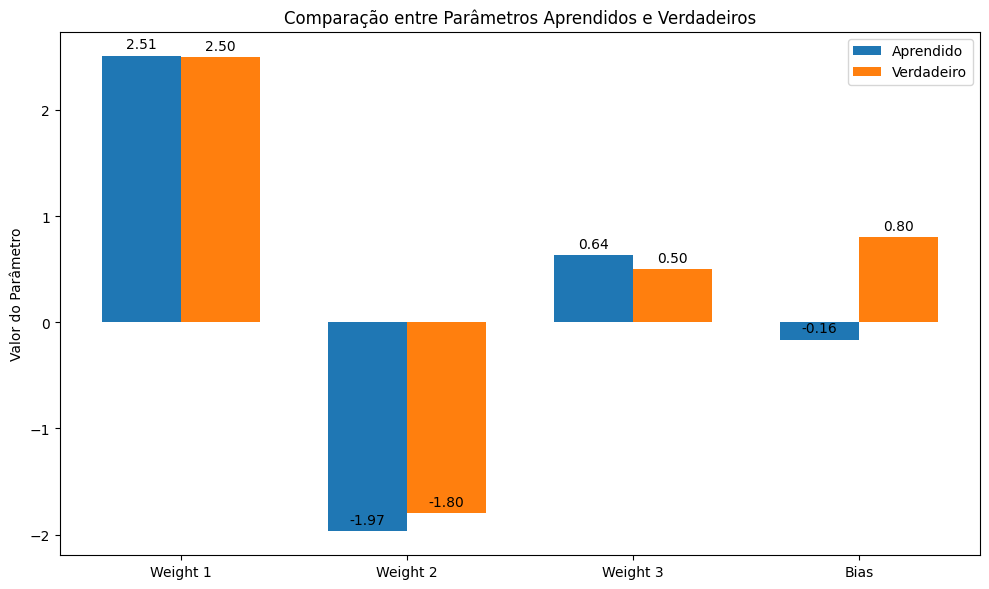

In [ ]:
# Parâmetros aprendidos
learned_weights = model_reg_multi.linear.weight.data.numpy().flatten()
learned_bias = model_reg_multi.linear.bias.data.numpy()

# Parâmetros verdadeiros
true_weights_flat = true_weights.numpy().flatten()
true_bias_flat = true_bias.numpy()

labels = [f'Weight {i+1}' for i in range(len(true_weights_flat))] + ['Bias']
learned_values = np.append(learned_weights, learned_bias)
true_values = np.append(true_weights_flat, true_bias_flat)

x_pos = np.arange(len(labels))
width = 0.35

# Desenhando
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_pos - width/2, learned_values, width, label='Aprendido')
rects2 = ax.bar(x_pos + width/2, true_values, width, label='Verdadeiro')

# Títulos e legendas
ax.set_ylabel('Valor do Parâmetro')
ax.set_title('Comparação entre Parâmetros Aprendidos e Verdadeiros')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# Rotulando valores para as barras
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Exercício 2: O Impacto da Taxa de Aprendizado ($\eta$)

A taxa de aprendizado ($\eta$) é um dos hiperparâmetros mais importantes no treinamento de redes neurais. Ela controla o tamanho dos passos dados durante a otimização para minimizar a função de custo, conforme a regra de atualização:

$$ \theta_{novo} = \theta_{antigo} - \eta \nabla J(\theta) $$

**Sua tarefa é investigar o efeito de diferentes taxas de aprendizado:**

#### 1.  **Treine o modelo original** (de uma feature, com dados sintéticos) usando três valores diferentes para `learning_rate`:
    * Um valor muito pequeno (ex: `1e-6`).
    * O valor que usamos (ex: `0.001`).
    * Um valor muito grande (ex: `0.1`).

In [ ]:
# Gerando dados sintéticos para regressão linear simples (1 feature)
num_points = 200
true_weight = torch.tensor([[2.5]])
true_bias = torch.tensor([0.8])
noise  = torch.randn(num_points, 1) * 16
X_reg_simple = torch.randn(num_points, 1) * 10
y_reg_simple = X_reg_simple * true_weight + true_bias + noise

# Taxas de aprendizado
learning_rates = {
    "Pequena (1e-6)": 1e-6,
    "Adequada (0.001)": 0.001,
    "Grande (0.1)": 0.1
}

all_losses = {}
loss_fn_reg = nn.MSELoss()

for name, lr in learning_rates.items():
    model_instance = SimpleLinearModel(in_features=1)
    optimizer_instance = torch.optim.SGD(model_instance.parameters(), lr=lr)

    losses = run_training_loop(
        model_instance, X_reg_simple, y_reg_simple, loss_fn_reg, optimizer_instance,
        epochs=200, desc=f"Treinando com LR={lr}"
    )
    all_losses[name] = losses

Treinando com LR=1e-06: 100%|██████████| 200/200 [00:00<00:00, 2522.60it/s]



Treinamento concluído! Perda final: 875.5408


Treinando com LR=0.001: 100%|██████████| 200/200 [00:00<00:00, 2624.84it/s]



Treinamento concluído! Perda final: 287.3224


Treinando com LR=0.1:  14%|█▍        | 29/200 [00:00<00:00, 2126.41it/s]


Perda se tornou NaN na época 29. Interrompendo.

Treinamento concluído! Perda final: inf


#### 2.  **Plote a curva de perda (MSE vs. Épocas)** para cada um dos três experimentos no mesmo gráfico.

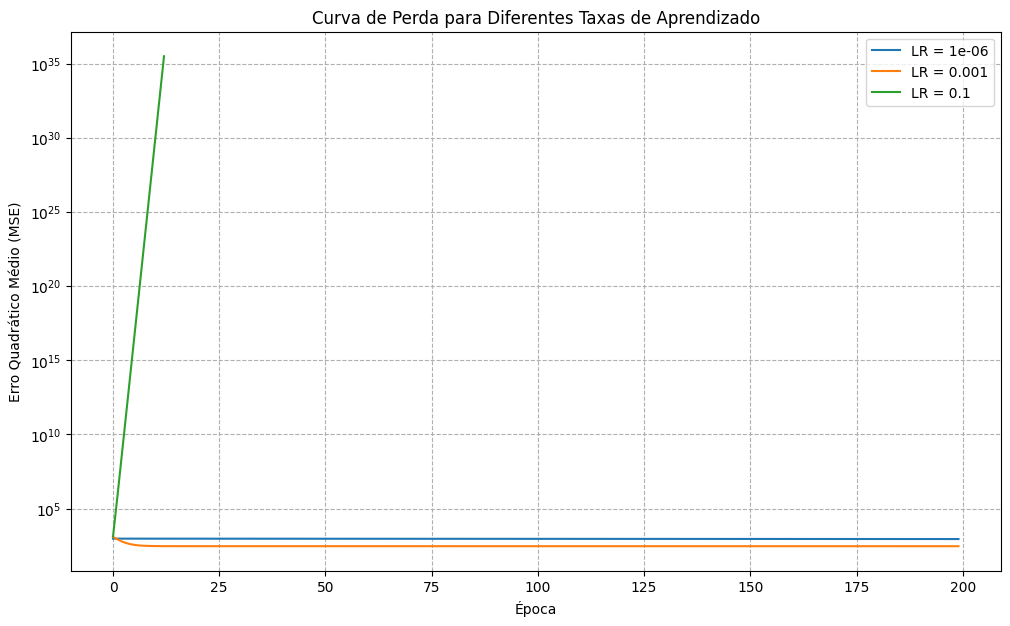

In [ ]:
plt.figure(figsize=(12, 7))
for name, losses in all_losses.items():
    plt.plot(range(len(losses)), losses, label=f'LR = {learning_rates[name]}')

plt.title("Curva de Perda para Diferentes Taxas de Aprendizado")
plt.xlabel("Época")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

#### 3.  **Analise e descreva** o que você observa em cada caso:

*   O que acontece quando  η  é muito pequeno? A convergência é rápida ou lenta?

* * Quando a taxa de aprendizado é muito pequena (ex: 1e-6), a curva de perda (azul) permanece plana e estagnada em um valor muito alto. Isso indica que os passos dados para ajustar os pesos do modelo são tão minúsculos que o modelo não consegue aprender. A convergência é inefetivamente lenta, ao ponto de não haver progresso nas 200 épocas.
*   O que acontece quando  η  é muito grande? O modelo consegue convergir? O que o comportamento da curva de perda sugere?

* * Quando a taxa de aprendizado é muito grande, a perda explode, subindo para um valor na casa de 10^36, quase que instantaneamente. Isso ocorre porque os passos do otimizador são tão grandes que eles pulam o ponto de mínimo da função de custo e divergem. O comportamento da curva verde sugere instabilidade e divergência, fazendo com que o modelo falhe em aprender.

## Exercícios: Regressão Logística

### Exercício 1: Portas Lógicas AND e OR

As portas lógicas são os blocos de construção fundamentais da computação digital. Sua tarefa é usar a Regressão Logística para modelar as portas **AND** e **OR**.

**Tabelas Verdade:**

| $x_1$ | $x_2$ | AND | OR |
|:---:|:---:|:---:|:--:|
| 0   | 0   | 0   | 0  |
| 0   | 1   | 0   | 1  |
| 1   | 0   | 0   | 1  |
| 1   | 1   | 1   | 1  |

**Passos:**

#### 1.  **Crie dois datasets**: um para a porta AND e outro para a porta OR. Cada dataset deve conter múltiplos exemplos para cada uma das quatro combinações de entrada (ex: 20 pontos para `(0,0)`, 20 para `(0,1)`, etc.).

In [ ]:
# Número de exemplos
pontos = 30

# Entradas
entradas = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
X_base = np.repeat(entradas, pontos, axis=0)

# Porta AND
y_and = np.array([0, 0, 0, 1])
y_and = np.repeat(y_and, pontos, axis=0).reshape(-1, 1)
dataset_and = np.hstack((X_base, y_and))

# Porta OR
y_or = np.array([0, 1, 1, 1])
y_or = np.repeat(y_or, pontos, axis=0).reshape(-1, 1)
dataset_or = np.hstack((X_base, y_or))

#### 2.  **Adicione um pouco de ruído gaussiano** aos dados de entrada $X$ para que os pontos não sejam exatamente 0 ou 1. Isso torna o problema de classificação mais realista.

In [ ]:
X_ruidosa = X_base + np.random.normal(scale=0.1, size=X_base.shape)
X_log_tensor = torch.from_numpy(X_ruidosa).float()
y_and_tensor = torch.from_numpy(y_and).float()
y_or_tensor = torch.from_numpy(y_or).float()

#### 3.  **Treine um modelo de Regressão Logística** para cada porta lógica. 4.  **Plote a fronteira de decisão** para cada modelo treinado. Você deve observar que o modelo consegue encontrar uma linha reta que separa perfeitamente as classes 0 e 1 para ambas as portas, pois elas são problemas **linearmente separáveis**.

--- Treinando Modelo para Porta AND ---


Treinando o modelo: 100%|██████████| 1000/1000 [00:00<00:00, 2243.92it/s]



Treinamento concluído! Perda final: 0.1475


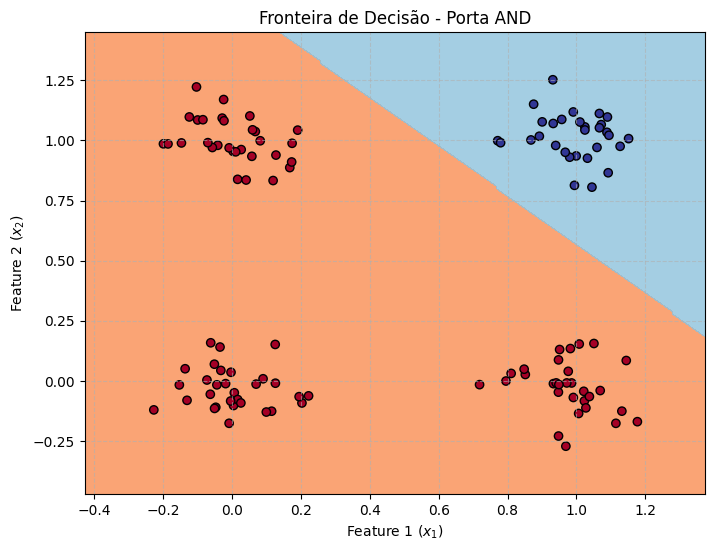


--- Treinando Modelo para Porta OR ---


Treinando o modelo: 100%|██████████| 1000/1000 [00:00<00:00, 2542.53it/s]



Treinamento concluído! Perda final: 0.0988


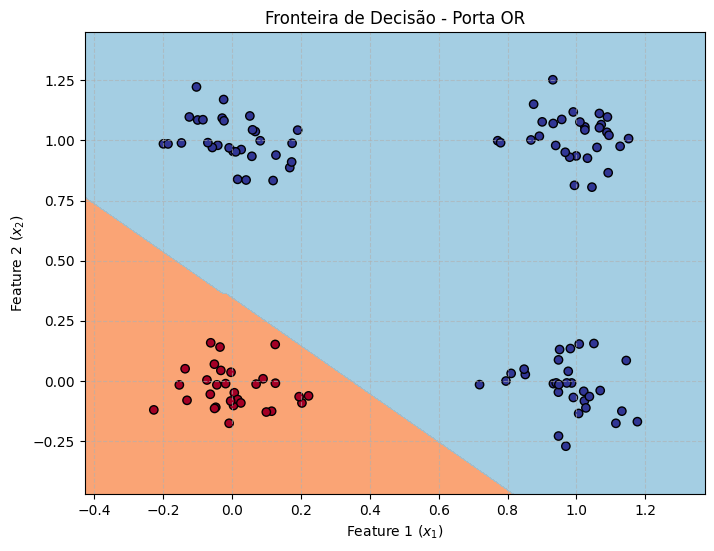

In [ ]:
# Definindo a função de custo para classificação
loss_fn_log = nn.BCEWithLogitsLoss()

# --- Treinamento para Porta AND ---
print("--- Treinando Modelo para Porta AND ---")
model_and = SimpleLinearModel(in_features=2)
optimizer_and = torch.optim.SGD(model_and.parameters(), lr=0.1)
run_training_loop(
    model_and, X_log_tensor, y_and_tensor, loss_fn_log, optimizer_and, epochs=1000
)
plot_decision_boundary(model_and, X_log_tensor, y_and_tensor, "Fronteira de Decisão - Porta AND")

# --- Treinamento para Porta OR ---
print("\n--- Treinando Modelo para Porta OR ---")
model_or = SimpleLinearModel(in_features=2)
optimizer_or = torch.optim.SGD(model_or.parameters(), lr=0.1)
run_training_loop(
    model_or, X_log_tensor, y_or_tensor, loss_fn_log, optimizer_or, epochs=1000
)
plot_decision_boundary(model_or, X_log_tensor, y_or_tensor, "Fronteira de Decisão - Porta OR")

### Exercício 2: O Desafio da Porta Lógica XOR

Agora, vamos tentar o mesmo com a porta **XOR** (OU exclusivo).

**Tabela Verdade XOR:**

| $x_1$ | $x_2$ | XOR |
|:---:|:---:|:---:|
| 0   | 0   | 0   |
| 0   | 1   | 1   |
| 1   | 0   | 1   |
| 1   | 1   | 0   |

**Passos:**

#### 1.  **Crie um dataset para a porta XOR**, seguindo a mesma abordagem do exercício anterior (múltiplos pontos com ruído para cada combinação de entrada).

In [ ]:
# Mesma entrada do exercício anterior (X_log_tensor)
y_xor = np.repeat(np.array([0, 1, 1, 0]), pontos, axis=0).reshape(-1, 1)
y_xor_tensor = torch.from_numpy(y_xor).float()

#### 2.  **Treine um modelo de Regressão Logística** para classificar os dados XOR. 3.  **Plote a fronteira de decisão** e a curva de acurácia.


--- Treinando Modelo para Porta XOR ---


Treinando o modelo: 100%|██████████| 1000/1000 [00:00<00:00, 2502.51it/s]



Treinamento concluído! Perda final: 0.6931


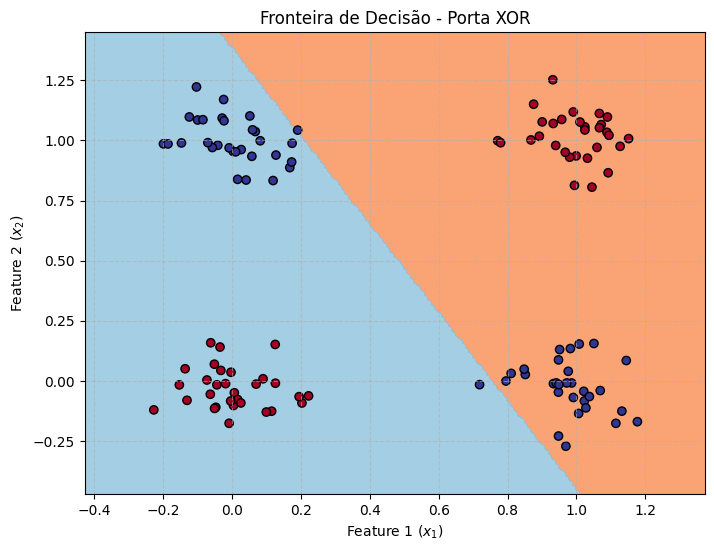

In [ ]:
print("\n--- Treinando Modelo para Porta XOR ---")
model_xor = SimpleLinearModel(in_features=2)
optimizer_xor = torch.optim.SGD(model_xor.parameters(), lr=0.1)
run_training_loop(
    model_xor, X_log_tensor, y_xor_tensor, loss_fn_log, optimizer_xor, epochs=1000
)
plot_decision_boundary(model_xor, X_log_tensor, y_xor_tensor, "Fronteira de Decisão - Porta XOR")

#### 4.  **Analise e responda**:
* O que você observa no gráfico da fronteira de decisão?
* * O gráfico mostra que o modelo linear tenta (sem sucesso) traçar uma linha reta para separar as classes; Isto acontece porque o problema XOR não é linearmente separável.
* Qual a acurácia máxima que o seu modelo consegue atingir? Por que você acha que ela fica estagnada em torno desse valor?
* * O modelo consegue predizer 50% das saídas de cada classe corretamente. Porque uma linha única não consegue dividir pontos do primeiro e quarto quadrante dos pontos no segundo e terceiro quadrante.
* É possível traçar uma **única linha reta** que separe as saídas da classe 0 (pontos `(0,0)` e `(1,1)`) das saídas da classe 1 (pontos `(0,1)` e `(1,0)`)?
* * Não. A explicação dos quadrantes na questão anterior responde isso.